In [1]:
import matplotlib.pyplot as pl
import numpy as np
import itertools

import fna.tools.utils.logger
logger = fna.tools.utils.logger.get_logger(__name__)
logger.propagate = False

# **1. Symbolic input sequences** <a id='section1'></a>

For simplicity and in order to specify all tasks using a common formalism, we implement input/output relations in symbolic terms.

Why symbolic sequences?
* All temporal tasks can be defined in these terms - flexibility

In this section, we will exemplify the use of the symbolic sequencers and their metrics...

In [2]:
# parameters to use in the examples
seq_length = 10000 # for random sequences
n_strings = 10000

### 1.1. The `SymbolicSequencer` base class and tools 



In [3]:
from fna.tasks.symbolic.sequences import SymbolicSequencer

vocabulary_size = 10
random_sequencer = SymbolicSequencer(label='random', set_size=vocabulary_size)

print("\nExample sequence: " + str(random_sequencer.generate_random_sequence(T=seq_length)[:30]))

[sequences.py:132 - INFO] Generating symbolic sequencer
[sequences.py:161 - INFO] Generating a random sequence of length 10000, from a set of 10 symbols



Example sequence: ['3', '4', '2', '2', '8', '0', '3', '8', '9', '3', '6', '6', '0', '6', '8', '8', '9', '1', '5', '6', '2', '2', '1', '9', '6', '9', '9', '2', '8', '1']


In [13]:
method_list = [func for func in dir(random_sequencer) if callable(getattr(random_sequencer, func)) and not func.startswith("__")]
method_list

['_chunk_targets',
 '_concatenate_stringset',
 '_memory_targets',
 '_prediction_targets',
 'compressibility',
 'count',
 'draw_subsequences',
 'entropy',
 'generate_default_outputs',
 'generate_random_sequence',
 'most_common',
 'string_length',
 'string_set_complexity',
 'topographical_entropy']

### 1.2. Designing sequences with tokens and transition tables - `ArtificialGrammar`

Any arbitrarily complex sequence can be described by a series of unique states and associated transition rules. This class implements such functionality.

In [5]:
from fna.tasks.symbolic import ArtificialGrammar

An artificial grammar object is created using the following parameter structure. 

**NOTE:** While it is common in the literature to specify artificial grammars where the symbols are emitted on the transitions, we chose a graph representation whereby symbols are the nodes / states in the graph and assign transition probabilities. So, the former graphs need to be adjusted accordingly, see below.

To exemplify, we generate the Elman language, which consists of three, randomly alternating *pseudo-words*: $\mathrm{b a}$, $\mathrm{d i i}$, $\mathrm{g u u}$.  

In [6]:
Elman = {    
    # Sequencer label
    'label': 'Elman', 
    
    # list of unique tokens
    'alphabet': ['b', 'a', 'd', 'i', 'g', 'u'], 
    
    # list of unique states in the graph (may or may not be = alphabet)
    'states': ['b', 'a', 'd', 'i1', 'i2', 'g', 'u1', 'u2', 'u3'], 
    
    # initial and terminal states
    'start_states': ['b', 'd', 'g'], 
    'terminal_states': ['a', 'i2', 'u3'],
    
    # state transition probabilities as a list of tuples (start, end, p)
    'transitions': [
        ('b', 'a', 1.),
        ('d', 'i1', 1.),
        ('i1', 'i2', 1.),
        ('g', 'u1', 1.),
        ('u1', 'u2', 1.),
        ('u2', 'u3', 1.)],
}

Using parameter with the structure exemplified, we can construct an `ArtificialGrammar` instance and generate a set of `n_strings` correct strings from which we build a sequence, by traversing the grammar:

In [7]:
elman = ArtificialGrammar(**Elman)
elman.generate_string_set(n_strings=n_strings, correct_strings=True)
print("\nExample strings: " + str(elman.string_set[:10]))
print("\nExample sequence: " + str(elman.generate_sequence()[:30]))

[sequences.py:132 - INFO] Generating symbolic sequencer
[__init__.py:144 - INFO] ***************************************************************************
[__init__.py:146 - INFO] Generative mechanism: Elman
[__init__.py:147 - INFO] Unique states: ['b', 'a', 'd', 'i1', 'i2', 'g', 'u1', 'u2', 'u3']
[__init__.py:148 - INFO] Alphabet: ['a', 'b', 'd', 'g', 'i', 'u']
[__init__.py:155 - INFO] Transition table: 
[__init__.py:213 - INFO] Generating 10000 strings, according to Elman rules
[__init__.py:225 - INFO] Example String: ba


      b    a    d   i1   i2    g   u1   u2   u3
b   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
a   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
d   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
i1  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
i2  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
g   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
u1  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
u2  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
u3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0

Example strings: [['b', 'a'], ['b', 'a'], ['g', 'u', 'u', 'u'], ['g', 'u', 'u', 'u'], ['b', 'a'], ['b', 'a'], ['d', 'i', 'i'], ['d', 'i', 'i'], ['g', 'u', 'u', 'u'], ['b', 'a']]

Example sequence: ['b', 'a', 'b', 'a', 'g', 'u', 'u', 'u', 'g', 'u', 'u', 'u', 'b', 'a', 'b', 'a', 'd', 'i', 'i', 'd', 'i', 'i', 'g', 'u', 'u', 'u', 'b', 'a', 'g', 'u']


**NOTE**: in the final sequence, the strings are concatenated, without any separation (*eos marker*). This could be easily modyfied by including it as the terminal state, or by manually setting this parameter and re-drawing the sequence:

In [7]:
elman.eos = '#'
print("Example sequence (with eos): " + str(elman.generate_sequence()[:30]))

Example sequence (with eos): ['g', 'u', 'u', 'u', '#', 'g', 'u', 'u', 'u', '#', 'b', 'a', '#', 'b', 'a', '#', 'd', 'i', 'i', '#', 'b', 'a', '#', 'd', 'i', 'i', '#', 'd', 'i', 'i']


We can also, for comparison purposes, draw a random sequence, composed of the same tokens:

In [8]:
rnd_elman_seq = elman.generate_random_sequence(T=len(elman.generate_sequence()))
print("\nExample random sequence: " + str(rnd_elman_seq[:30]))

[sequences.py:161 - INFO] Generating a random sequence of length 40116, from a set of 6 symbols



Example random sequence: ['i', 'g', 'd', 'd', 'b', 'd', 'd', 'u', 'g', 'b', 'a', 'd', 'b', 'g', 'b', 'b', 'u', 'a', 'i', 'u', 'g', 'i', 'i', 'i', 'i', 'a', 'b', 'a', 'u', 'g']


Let's repeat the process for a variety of other, more complex rule systems.

In [9]:
# A.b) Reber grammar
FSG_G1 = {
    'label': 'Reber Grammar',
    'states': ['M1', 'V2', 'T1', 'V1', 'T2', 'R1', 'X1', 'X2', 'R2', 'M2', '#'],
    'alphabet': ['M', 'V', 'T', 'R', 'X', '#'],
    'start_states': ['M1', 'V2'],
    'terminal_states': ['#'],
    'transitions': [
            ('M1', 'T1', 0.5),
            ('M1', 'V1', 0.5),
            ('T1', 'T1', 0.5),
            ('T1', 'V1', 0.5),
            ('V1', 'T2', 1. / 3.),
            ('V1', 'R1', 1. / 3.),
            ('V1', '#', 1. / 3.),
            ('T2', '#', 1.),
            ('R1', 'X1', 0.5),
            ('R1', 'X2', 0.5),
            ('V2', 'X1', 0.5),
            ('V2', 'X2', 0.5),
            ('X1', 'T1', 0.5),
            ('X1', 'V1', 0.5),
            ('X2', 'R2', 1. / 3.),
            ('X2', 'M2', 1. / 3.),
            ('X2', '#', 1. / 3.),
            ('R2', 'R2', 1. / 3.),
            ('R2', 'M2', 1. / 3.),
            ('R2', '#', 1. / 3.),
            ('M2', '#', 1.)],
    'eos': '#'
    }

# build artificial grammar
reber = ArtificialGrammar(**FSG_G1)

# generate string set
reber.generate_string_set(n_strings=n_strings, str_range=(1, 10000), correct_strings=True, nongramm_fraction=0.) # TODO - implement nongrammatical strings

# generate input sequence
reber_seq = reber.generate_sequence()
rnd_reber_seq = reber.generate_random_sequence(T=seq_length)

print("\nExample strings: " + str(reber.string_set[:10]))
print("\nExample sequence: " + str(reber_seq[:30]))
print("\nExample random sequence: " + str(rnd_reber_seq[:30]))

[sequences.py:132 - INFO] Generating symbolic sequencer
[__init__.py:144 - INFO] ***************************************************************************
[__init__.py:146 - INFO] Generative mechanism: Reber Grammar
[__init__.py:147 - INFO] Unique states: ['M1', 'V2', 'T1', 'V1', 'T2', 'R1', 'X1', 'X2', 'R2', 'M2', '#']
[__init__.py:148 - INFO] Alphabet: ['#', 'M', 'R', 'T', 'V', 'X']
[__init__.py:155 - INFO] Transition table: 
[__init__.py:213 - INFO] Generating 10000 strings, according to Reber Grammar rules


     M1   V2   T1        V1   T2   R1   X1        X2        R2   M2    #
M1  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0
V2  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0
T1  0.5  0.0  0.5  0.000000  0.0  0.0  0.5  0.000000  0.000000  0.0  0.0
V1  0.5  0.0  0.5  0.000000  0.0  0.0  0.5  0.000000  0.000000  0.0  0.0
T2  0.0  0.0  0.0  0.333333  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0
R1  0.0  0.0  0.0  0.333333  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0
X1  0.0  0.5  0.0  0.000000  0.0  0.5  0.0  0.000000  0.000000  0.0  0.0
X2  0.0  0.5  0.0  0.000000  0.0  0.5  0.0  0.000000  0.000000  0.0  0.0
R2  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.333333  0.333333  0.0  0.0
M2  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.333333  0.333333  0.0  0.0
#   0.0  0.0  0.0  0.333333  1.0  0.0  0.0  0.333333  0.333333  1.0  0.0


[__init__.py:225 - INFO] Example String: VXTVT
[sequences.py:161 - INFO] Generating a random sequence of length 10000, from a set of 5 symbols



Example strings: [['V', 'X', 'T', 'V', 'T'], ['V', 'X', 'M'], ['V', 'X', 'V', 'R', 'X', 'T', 'T', 'T', 'T', 'V', 'R', 'X'], ['M', 'T', 'T', 'T', 'V'], ['V', 'X', 'V'], ['M', 'T', 'V', 'R', 'X', 'R', 'R', 'M'], ['V', 'X'], ['M', 'T', 'T', 'V', 'R', 'X', 'R', 'M'], ['V', 'X', 'T', 'T', 'V', 'T'], ['M', 'V', 'R', 'X']]

Example sequence: ['V', 'X', 'T', 'V', 'T', '#', 'V', 'X', 'M', '#', 'V', 'X', 'V', 'R', 'X', 'T', 'T', 'T', 'T', 'V', 'R', 'X', '#', 'M', 'T', 'T', 'T', 'V', '#', 'V']

Example random sequence: ['T', 'T', 'T', 'M', 'R', 'X', 'R', 'R', 'R', 'M', 'X', 'R', 'T', 'R', 'T', 'T', 'M', 'M', 'M', 'T', 'R', 'M', 'M', 'R', 'M', 'X', 'R', 'R', 'R', 'R']


### 1.3. Sequences with variable non-adjacent dependencies - `NonAdjacentDependencies`

For further details on the task and its relevance and use see [below](#section3)

In [10]:
from fna.tasks.symbolic import NonAdjacentDependencies

vocabulary_size = 2
filler_variability = 1
dependency_length = 4

nad = NonAdjacentDependencies(vocabulary_size, filler_variability, dependency_length)
# nad.eos = '#'
nad.generate_stringset(set_length=n_strings, generator=False, violations=None)

print("\nExample strings: " + str(nad.string_set[:10]))
print("\nExample sequence: " + str(nad.generate_sequence()[:30]))
print("\nExample random sequence: " + str(nad.generate_random_sequence(T=seq_length)[:30]))

[sequences.py:132 - INFO] Generating symbolic sequencer
[__init__.py:79 - INFO] Generating 10000 strings, according to nAD rules...



Example strings: [['A0', 'X0', 'X0', 'X0', 'X0', 'B0'], ['A1', 'X0', 'X0', 'X0', 'X0', 'B1'], ['A0', 'X0', 'X0', 'X0', 'X0', 'B0'], ['A1', 'X0', 'X0', 'X0', 'X0', 'B1'], ['A0', 'X0', 'X0', 'X0', 'X0', 'B0'], ['A1', 'X0', 'X0', 'X0', 'X0', 'B1'], ['A0', 'X0', 'X0', 'X0', 'X0', 'B0'], ['A0', 'X0', 'X0', 'X0', 'X0', 'B0'], ['A1', 'X0', 'X0', 'X0', 'X0', 'B1'], ['A0', 'X0', 'X0', 'X0', 'X0', 'B0']]


[sequences.py:161 - INFO] Generating a random sequence of length 10000, from a set of 5 symbols



Example sequence: ['A0', 'X0', 'X0', 'X0', 'X0', 'B0', '.', 'A1', 'X0', 'X0', 'X0', 'X0', 'B1', '.', 'A0', 'X0', 'X0', 'X0', 'X0', 'B0', '.', 'A1', 'X0', 'X0', 'X0', 'X0', 'B1', '.', 'A0', 'X0']

Example random sequence: ['B0', 'B0', 'B1', 'X0', 'B0', 'A0', 'A1', 'A1', 'X0', 'X0', 'X0', 'A1', 'A0', 'X0', 'X0', 'X0', 'B1', 'X0', 'B0', 'B0', 'B0', 'X0', 'A1', 'A1', 'A0', 'X0', 'A1', 'A0', 'B0', 'B0']


### 1.4. 1-2-A-X Continuous working memory task - `12AX`

### 1.5. Natural language data - `NaturalLanguage` 

In [11]:
from fna.tasks.symbolic import NaturalLanguage

# a) "Manual" sentences
process_sentences = ["""At eight o'clock on Thursday morning Arthur didn't feel very good."""]
lang = NaturalLanguage(label="example sentence", text_data=process_sentences, character_level=False)

# b) From corpus
corpus_label = "treebank"
lang_corp = NaturalLanguage(label=corpus_abel, text_data=None, character_level=False)
# lang_corp.display_parse_tree()

# c) character-level processing
lang_char = NaturalLanguage(label="sentence character", text_data=process_sentences, character_level=True)

print("\nExample strings: " + str(lang_corp.string_set[:5]))
print("\nExample sequence: " + str(lang_corp.sequence[:30]))
print("\nExample random sequence: " + str(lang_corp.generate_random_sequence(T=seq_length)[:30]))

[sequences.py:132 - INFO] Generating symbolic sequencer
[__init__.py:328 - INFO] ***************************************************************************
[__init__.py:330 - INFO] Natural Language: example sentence
[__init__.py:331 - INFO] Number of strings: 0
[__init__.py:332 - INFO] Vocabulary size: 13
[__init__.py:333 - INFO] Sequence length: 13
[__init__.py:334 - INFO] Most common: [('At', 1), ('eight', 1), ("o'clock", 1), ('on', 1), ('Thursday', 1), ('morning', 1), ('Arthur', 1), ('did', 1), ("n't", 1), ('feel', 1)]
[__init__.py:289 - INFO] Loading treebank corpus from nltk
[sequences.py:132 - INFO] Generating symbolic sequencer
[__init__.py:328 - INFO] ***************************************************************************
[__init__.py:330 - INFO] Natural Language: treebank
[__init__.py:331 - INFO] Number of strings: 3827
[__init__.py:332 - INFO] Vocabulary size: 12408
[__init__.py:333 - INFO] Sequence length: 100676
[__init__.py:334 - INFO] Most common: [(',', 4885), ('the


Example strings: [['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group'], ['Rudolph', 'Agnew', ',', '55', 'years', 'old', 'and', 'former', 'chairman', 'of', 'Consolidated', 'Gold', 'Fields', 'PLC', ',', 'was', 'named', '*-1', 'a', 'nonexecutive', 'director', 'of', 'this', 'British', 'industrial', 'conglomerate'], ['A', 'form', 'of', 'asbestos', 'once', 'used', '*', '*', 'to', 'make', 'Kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of', 'workers', 'exposed', '*', 'to', 'it', 'more', 'than', '30', 'years', 'ago', ',', 'researchers', 'reported', '0', '*T*-1'], ['The', 'asbestos', 'fiber', ',', 'crocidolite', ',', 'is', 'unusually', 'resilient', 'once', 'it', 'enters', 'the', 'lungs', ',', 'with', 'even', 'brief', 'exposures', 'to', 'it', 'causing', 'symptoms', 'that', '*T*-1', 'show', 'up', 'decades', 'later', ',', 'researchers', 'said', '0', '*T*-2'], ['Lorill

(...)

## **2. Evaluate sequences - complexity and token frequency** <a id='section2'></a>

In [12]:
from fna.tools.visualization.plotting import plot_from_dict, recurrence_plot, plot_histogram, plot_matrix
from fna.tools.visualization.helper import label_bars, get_cmap
from fna.tools.utils.operations import empty

In [13]:
# evaluation parameters
n_strings = 1000

In [14]:
seq_objects = [random_sequencer, elman, reber, nad, lang, lang_corp, lang_char]
sequences = [random_sequencer.generate_random_sequence(T=n_strings), elman.generate_sequence(), reber.generate_sequence(), nad.generate_sequence(), lang.sequence, lang_corp.sequence, lang_char.sequence]
random_sequences = [x.generate_random_sequence(T=len(y)) for x, y in zip(seq_objects, sequences)]

[sequences.py:161 - INFO] Generating a random sequence of length 1000, from a set of 10 symbols
[sequences.py:161 - INFO] Generating a random sequence of length 1000, from a set of 10 symbols
[sequences.py:161 - INFO] Generating a random sequence of length 40116, from a set of 6 symbols
[sequences.py:161 - INFO] Generating a random sequence of length 56325, from a set of 5 symbols
[sequences.py:161 - INFO] Generating a random sequence of length 69999, from a set of 5 symbols
[sequences.py:161 - INFO] Generating a random sequence of length 13, from a set of 13 symbols
[sequences.py:161 - INFO] Generating a random sequence of length 100676, from a set of 12408 symbols
[sequences.py:161 - INFO] Generating a random sequence of length 56, from a set of 13 symbols


### 2.1. Frequency distributions and set sizes

In [16]:
vocabulary_sizes = [len(x.tokens) for x in seq_objects]
string_lengths = [x.string_length() for x in seq_objects]

frequencies = [x.count(s, as_freq=True) for x, s in zip(seq_objects, sequences)]
freq_rnd = [x.count(s, as_freq=True) for x, s in zip(seq_objects, random_sequences)]

freq_common = [x.most_common(s, 10, as_freq=True) for x, s in zip(seq_objects, sequences)]

Vocabulary sizes: 
 10 [random]
 6 [Elman]
 5 [Reber Grammar]
 5 [nAD]
 13 [example sentence]
 12408 [treebank]
 13 [sentence character]


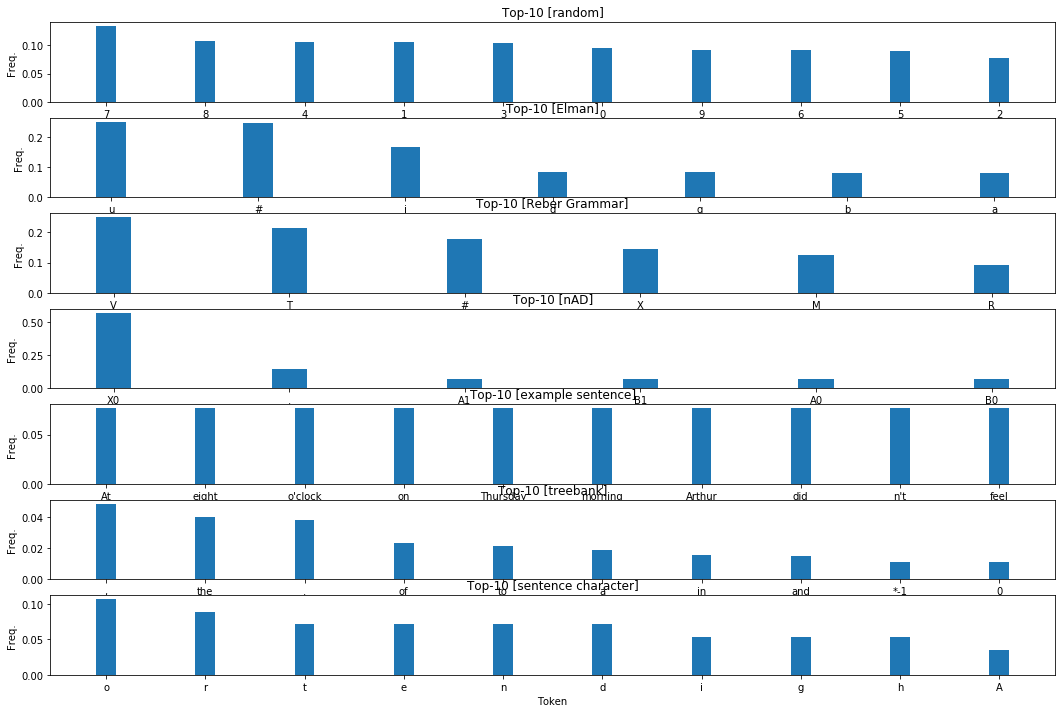

In [17]:
print("Vocabulary sizes: ")
[print(" {0!s} [{1!s}]".format(x, y.name)) for x, y in zip(vocabulary_sizes, seq_objects)]

fig2 = pl.figure(figsize=(18, 12))
axes = [fig2.add_subplot(len(freq_common), 1, x+1) for x in range(len(freq_common))]
[plot_from_dict(x, ax) for x, ax in zip(freq_common, axes)]
[ax.set_title("Top-10 [{0!s}]".format(x.name)) for x, ax in zip(seq_objects, axes)]
pl.show()

/home/neuro/Desktop/code/func-neurarch/tools/visualization/helper.py:127: RuntimeWarning: Mean of empty slice.
  ax.axvline(data.mean(), color=color, linestyle='dashed')
/home/neuro/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


[Text(0.5, 1.0, 'String length [random]: \nMean=nan'),
 Text(0.5, 1.0, 'String length [Elman]: \nMean=3.0117'),
 Text(0.5, 1.0, 'String length [Reber Grammar]: \nMean=4.6326'),
 Text(0.5, 1.0, 'String length [nAD]: \nMean=6.0'),
 Text(0.5, 1.0, 'String length [example sentence]: \nMean=nan'),
 Text(0.5, 1.0, 'String length [treebank]: \nMean=25.302064280114973'),
 Text(0.5, 1.0, 'String length [sentence character]: \nMean=nan')]

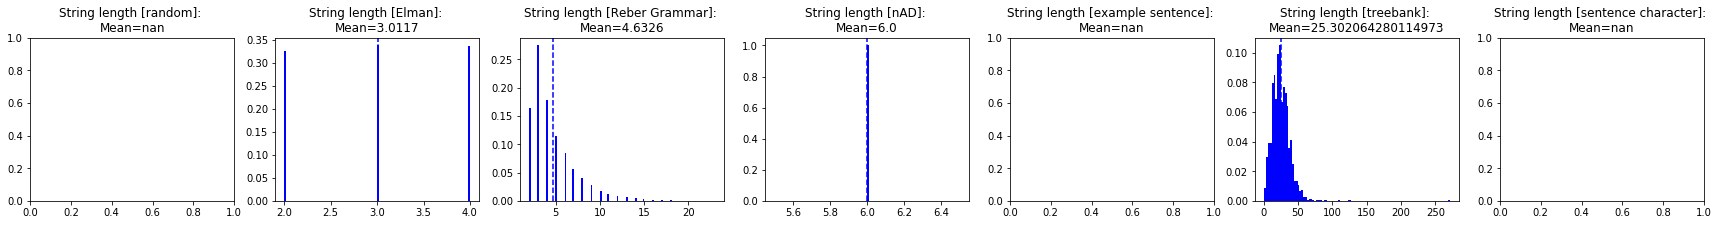

In [18]:
fig, axes = pl.subplots(1, len(string_lengths), figsize=(30, 3))


axes = [fig.add_subplot(1, len(string_lengths), x+1) for x in range(len(string_lengths))]
[plot_histogram(x, n_bins=100, mark_mean=True, ax=ax, display=False) for x, ax in zip(string_lengths, axes)]
[ax.set_title("String length [{0!s}]: \nMean={1!s}".format(x.name, np.mean(string_lengths[idx]))) for (idx, x), ax in zip(enumerate(seq_objects), axes)]
pl.show()

### 2.2. String-set complexity 
Compute the pairwise distances between strings to determine the mean complexity of the language. More complex languages will have larger mean distances.
* **Levenshtein distance** -- or minimum edit distance between two strings is the minimum numer of editing operations needed to convert one string into another. The editing operations can consist of insertions, deletions and substitutions.
* **Edit distance** -- total number of editing operations needed to convert one string to another
* **Hamming distance** -- 

**References**:
1. [Sequence complexity index](https://reader.elsevier.com/reader/sd/pii/S0304397504004098?token=40BF27E8706FAD1AD3CEC6D92BB0216F2DAA391AE968E569A63DBCE5DFF29EC542AE8C7B817338D38C0E4AD8D93AA67E)
2. [Levenshtein distance](https://www.python-course.eu/levenshtein_distance.php)
3. [other metrics 1](https://reader.elsevier.com/reader/sd/pii/S0022519311005017?token=E8640F60AE81256D53ADC2E5EF0602724B06186E8ED5CC39FF65D77477C4ABB4A12E0C2AB93F41C0D08D8110A9789DBE)
4. [improve implementation](https://pypi.org/project/edist/)

In [19]:
string_complexity = [x.string_set_complexity() for x in seq_objects]

[sequences.py:399 - INFO] Evaluating string set complexity...
Calculating pairwise distances: : 0it [00:00, ?it/s]
[sequences.py:399 - INFO] Evaluating string set complexity...
Calculating pairwise distances: 100%|██████████| 50005000/50005000 [11:32<00:00, 72203.42it/s]
[sequences.py:399 - INFO] Evaluating string set complexity...
Calculating pairwise distances: 100%|██████████| 50005000/50005000 [18:11<00:00, 45811.38it/s]
[sequences.py:399 - INFO] Evaluating string set complexity...
Calculating pairwise distances: 100%|██████████| 50005000/50005000 [37:15<00:00, 22365.10it/s]  
[sequences.py:399 - INFO] Evaluating string set complexity...
Calculating pairwise distances: : 0it [00:00, ?it/s]
[sequences.py:399 - INFO] Evaluating string set complexity...
Calculating pairwise distances: 100%|██████████| 7324878/7324878 [1:08:45<00:00, 1775.69it/s]
[sequences.py:399 - INFO] Evaluating string set complexity...
Calculating pairwise distances: : 0it [00:00, ?it/s]


[legend.py:1282 - WARNING] No handles with labels found to put in legend.
[legend.py:1282 - WARNING] No handles with labels found to put in legend.


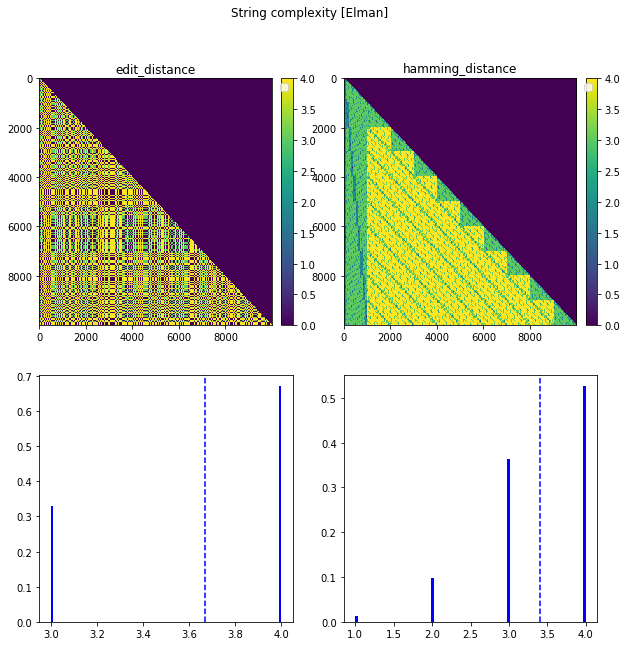

[legend.py:1282 - WARNING] No handles with labels found to put in legend.
[legend.py:1282 - WARNING] No handles with labels found to put in legend.


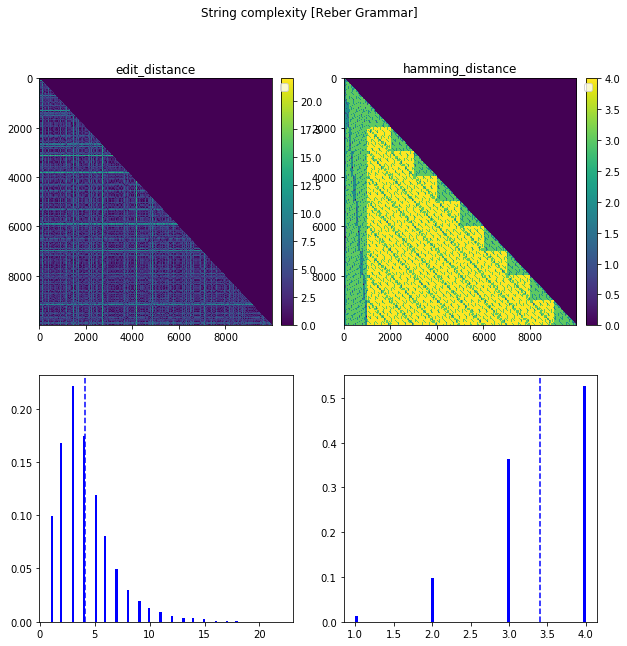

[legend.py:1282 - WARNING] No handles with labels found to put in legend.
[legend.py:1282 - WARNING] No handles with labels found to put in legend.


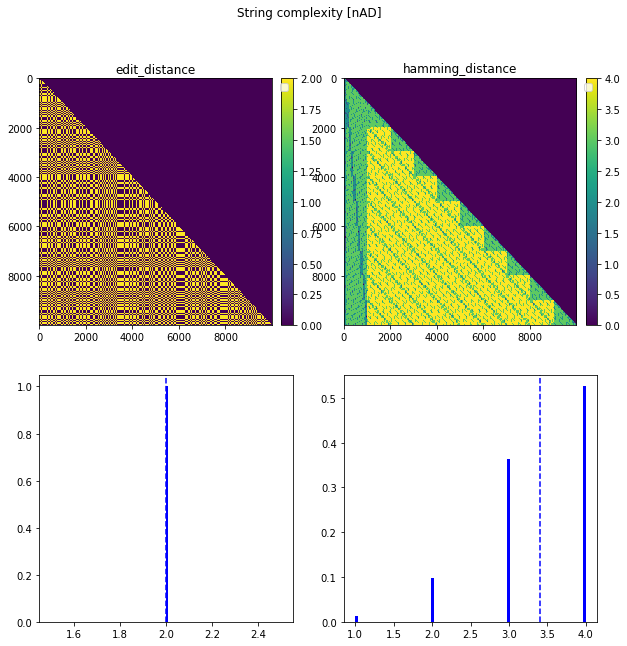

[legend.py:1282 - WARNING] No handles with labels found to put in legend.
[legend.py:1282 - WARNING] No handles with labels found to put in legend.


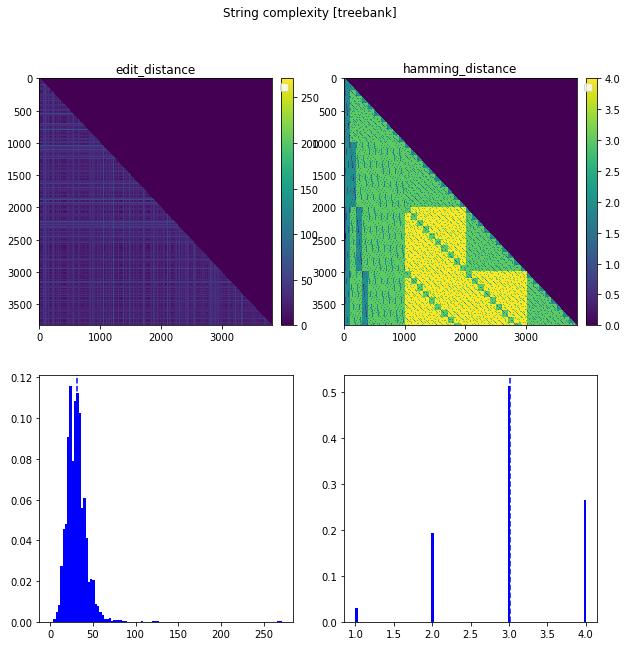

In [20]:
for idx, x in enumerate(string_complexity):
    if not empty(x['edit_distance']):
        fig, axes = pl.subplots(2, 2, figsize=(10, 10))
        fig.suptitle("String complexity [{0!s}]".format(seq_objects[idx].name))
        axes = list(itertools.chain(*axes))
        ax_idx = 0
        for k, v in x.items():
            plot_matrix(v, ax=axes[ax_idx], display=False)
            plot_histogram(v[v!=0.], 100, mark_mean=True, display=False, ax=axes[ax_idx+2], label=k)
            axes[ax_idx].set_title(k)
            ax_idx += 1
    pl.show()

### 2.3. Sequence complexity
When evaluating and comparing the ability of a system to process a given sequence, it is important to know how difficult the sequence is to process in the first place. To evaluate this, we introduce different metrics of sequence complexity (see []). In essence, these metrics evaluate the *richness of the language* underlying the sequence.

* **Entropy** -  Information Entropy, or Shannon Entropy is a measure of (un)predictability. A predictable sequence has low-entropy. The entropy of a sequence, denoted by H(S), is computed by:
$H(S)=-\sum_{i=0}^{T} P\left(S_{i}\right) \log _{2}\left(P\left(S_{i}\right)\right)$, where $P\left(S_{i}\right)$ is the relative frequency of character i within sequence S, with length T.

* **Compressibility**

* **Topographical Entropy** - see [1, 2, 3]


**References:**

[[1]](https://link.springer.com/article/10.1023%2FA%3A1009524428448) - Bollt and Jones (2000). *The complexity of Artificial Grammars*. Nonlinear Dynamics, Psychology, and Life Sciences volume 4, pages153–168(2000)

[[2]](https://www.frontiersin.org/articles/10.3389/fpsyg.2014.01084/full) - Schiff R and Katan P (2014) Does complexity matter? Meta-analysis of learner performance in artificial grammar tasks. Front. Psychol. 5:1084. 

[[3]](https://www.researchgate.net/publication/320508755_Topological_entropy_measure_of_artificial_grammar_complexity_for_use_in_designing_experiments_on_human_performance_in_intelligence_surveillance_and_reconnaissance_ISR_tasks/references) 

In [21]:
# measure sequence complexity
compressibility = [x.compressibility(s) for x, s in zip(seq_objects, sequences)]
comp_rnd = [x.compressibility(s) for x, s in zip(seq_objects, random_sequences)]

entropy = [x.entropy(s) for x, s in zip(seq_objects, sequences)]
ent_rnd = [x.entropy(s) for x, s in zip(seq_objects, random_sequences)]

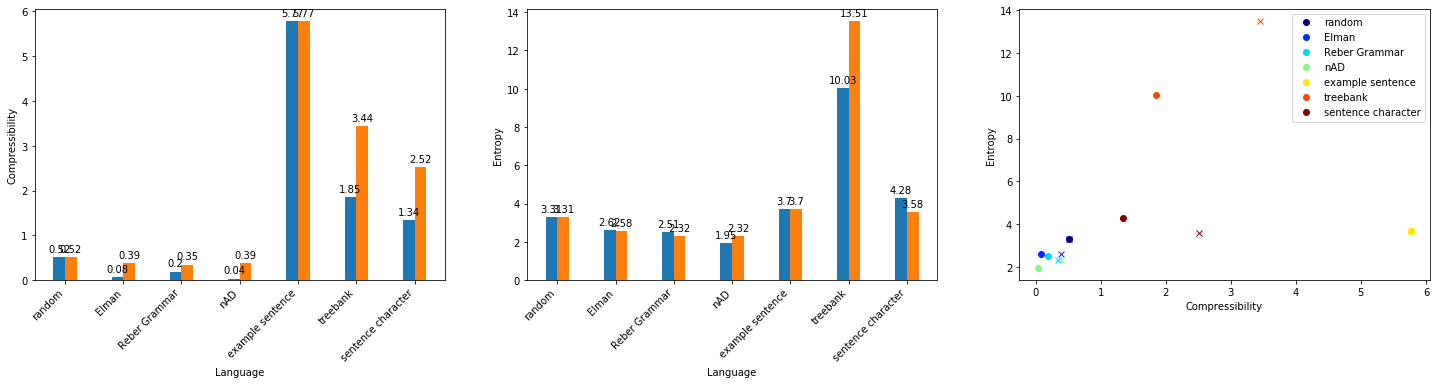

In [22]:
fig1 = pl.figure(figsize=(25, 5))
ax11 = fig1.add_subplot(1, 3, 1)
ax11.set_xlabel("Language")
ax11.set_ylabel("Compressibility")
ax11.set_xticks(np.arange(len(seq_objects)))
ax11.set_xticklabels([x.name for x in seq_objects], rotation=45, ha="right")

ax12 = fig1.add_subplot(1, 3, 2)
ax12.set_xlabel("Language")
ax12.set_ylabel("Entropy")
ax12.set_xticks(np.arange(len(seq_objects)))
ax12.set_xticklabels([x.name for x in seq_objects], rotation=45, ha="right")

ax13 = fig1.add_subplot(1, 3, 3)
ax13.set_xlabel("Compressibility")
ax13.set_ylabel("Entropy")
# ax13.set_xticklabels([x.name for x in seq_objects], rotation=45, ha="right")

comp1 = ax11.bar(np.arange(0, len(seq_objects), 1)-0.1, compressibility, width=0.2)
comp2 = ax11.bar(np.arange(0, len(seq_objects), 1)+0.1, comp_rnd, width=0.2)
label_bars(comp1, ax11)
label_bars(comp2, ax11)

comp1 = ax12.bar(np.arange(0, len(seq_objects), 1)-0.1, entropy, width=0.2)
comp2 = ax12.bar(np.arange(0, len(seq_objects), 1)+0.1, ent_rnd, width=0.2)
label_bars(comp1, ax12)
label_bars(comp2, ax12)

cmap = get_cmap(len(seq_objects), cmap='jet')
for idx, x in enumerate(seq_objects):
    ax13.plot(compressibility[idx], entropy[idx], 'o', color=cmap(idx), label=x.name)
    ax13.plot(comp_rnd[idx], ent_rnd[idx], 'x', color=cmap(idx))
ax13.legend()

### 2.4. Topographical Entropy

In [28]:
te = [x.topographical_entropy(s) for x, s in zip(seq_objects, sequences) if not isinstance(x, NaturalLanguage) and x.name != 'random']
#te_rnd = [x.topographical_entropy(s) for x, s in zip(seq_objects, random_seq) if not isinstance(x, NaturalLanguage)]

[sequences.py:242 - INFO] Computing topographical entropy..
[sequences.py:253 - INFO] Lift: 1; Entropy: 0.573283924732622
[sequences.py:253 - INFO] Lift: 2; Entropy: 0.42282157757191147
[sequences.py:253 - INFO] Lift: 3; Entropy: 0.2811995743229627
[sequences.py:253 - INFO] Lift: 4; Entropy: 0.2811995743229629
[sequences.py:242 - INFO] Computing topographical entropy..
[sequences.py:253 - INFO] Lift: 1; Entropy: 1.194763217287109
[sequences.py:253 - INFO] Lift: 2; Entropy: 0.7608446433781342
[sequences.py:253 - INFO] Lift: 3; Entropy: 0.7608446433781344
[sequences.py:242 - INFO] Computing topographical entropy..
[sequences.py:253 - INFO] Lift: 1; Entropy: 0.5587027319422304
[sequences.py:253 - INFO] Lift: 2; Entropy: 0.4725716395360864
[sequences.py:253 - INFO] Lift: 3; Entropy: 0.4119954281778819
[sequences.py:253 - INFO] Lift: 4; Entropy: 0.19804205158855556
[sequences.py:253 - INFO] Lift: 5; Entropy: 0.09902102579427823
[sequences.py:253 - INFO] Lift: 6; Entropy: 0.09902102579427702

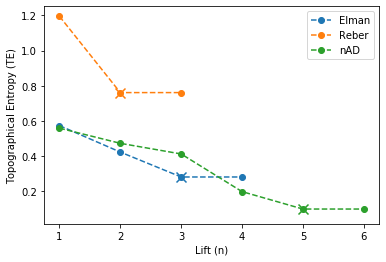

In [12]:
# Plot
import matplotlib.pyplot as pl
fig, ax = pl.subplots()
ax.set_xlabel("Lift (n)")
ax.set_ylabel("Topographical Entropy (TE)")

#labels = [x.name for x in seq_objects if not isinstance(x, NaturalLanguage) and x.name != 'random']
labels = ['Elman', "Reber", "nAD"]

lifts = [[1, 2, 3, 4], 
         [1, 2, 3],
         [1, 2, 3, 4, 5, 6]]
ents = [[0.573283924732622, 0.42282157757191147, 0.2811995743229627, 0.2811995743229629], 
        [1.194763217287109, 0.7608446433781342, 0.7608446433781344],
        [0.5587027319422304, 0.4725716395360864, 0.4119954281778819, 0.19804205158855556, 0.09902102579427823, 0.09902102579427702]]

for x, y, lab in zip(lifts, ents, labels): 
    ax.plot(x, y, 'o--', label=lab)
    ax.scatter(x[-2], y[-2], marker='x', s=100)
pl.legend()    
pl.show()